## Mounting the drive
You should add this link to your google drive. Click the folder. https://drive.google.com/drive/folders/13JW_d7k11Z5m7LGjp19GaADWEesZ2Av9?usp=share_link .In the top right, click Add a shortcut to My Drive.

Form Link: https://docs.google.com/forms/d/1kmrK2F8g6TkQU0wD5jS4CHXT6ugI19566azV4WJpp0I/edit

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
# import the necessary packages
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
class PanoramaGenerator:
    def generate_panorama_image(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageA, imageB) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None

        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M



        # Student Code: apply the warping on the 2nd image
        #  cv2.warpPerspective(right image, homography_matrix, (width, height))
        # 1 line of code
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))


        # End Student Code
        result[0:imageB.shape[0], 0:imageB.shape[1]] =imageB
        #cv2_imshow(result)

        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
                status)

            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # Student Code: convert the image to grayscale
        # ~ 1 line of code
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # End Student Code

        # Student Code: detect and extract keypoint descriptors from the image using SIFT
        # ~ 2 lines of code
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(gray, None)
        # End Student Code

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.BFMatcher()

        # Student Code: for matching, use: matcher.knnMatch(QueryImageDescriptors, TrainImageDescriptors, k)
        # ~ 1 line of code
        rawMatches =matcher.knnMatch(featuresA, featuresB, 2)
        # End Student Code

        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # Student Code: ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
            # That is if the distance of the top match is less than a ratio multiplied by the 2nd top match
            # then add the top match features indices (a tuple of train and query indices) to the matches list,
            # otherwise, do nothing. Hint: you will need DMatch.distance, DMatch.queryIdx, DMatch.trainIdx
            # 2 lines of code
            if m[0].distance<(ratio*m[1].distance):
              matches.append((m[0].trainIdx,m[0].queryIdx))
            # End Student Code

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # Student Code: construct the two sets of points
            # Replace the ??? with the exact words to get the keypoint of image a and image b
            ptsA = np.float32([kpsA[ind] for (_, ind) in matches])
            ptsB = np.float32([kpsB[ind] for (ind, _) in matches])
            # Hint:
            # An example of using list comprehension to get a list of the first element in a 2d array:
            # first_column:  [row[0] for row in two_dimension_array]
            # 2 lines of code:
            # End Student Code

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis

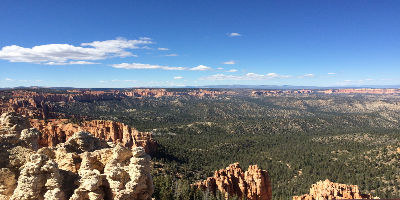

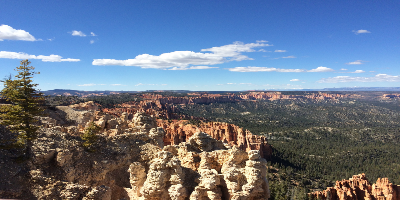

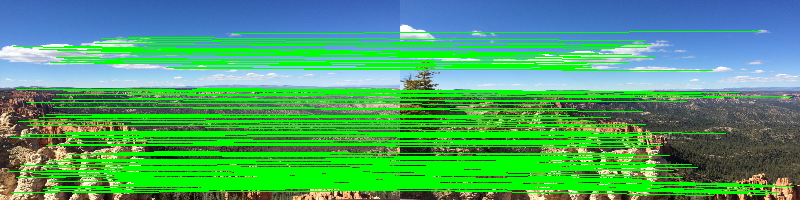

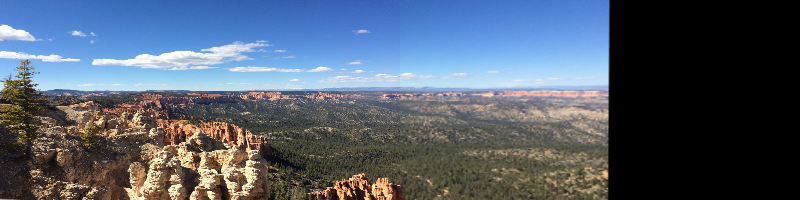

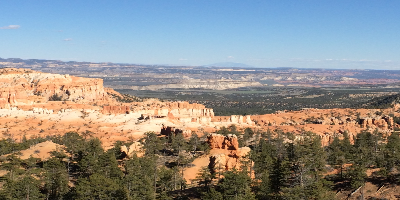

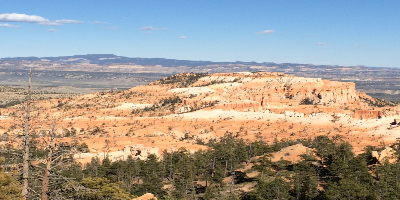

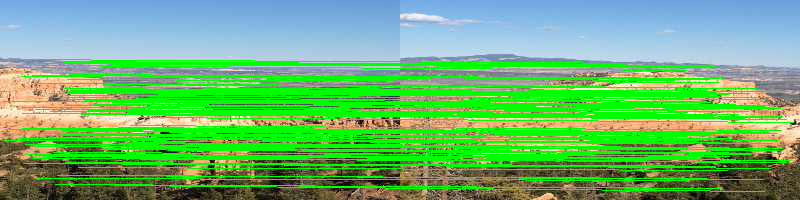

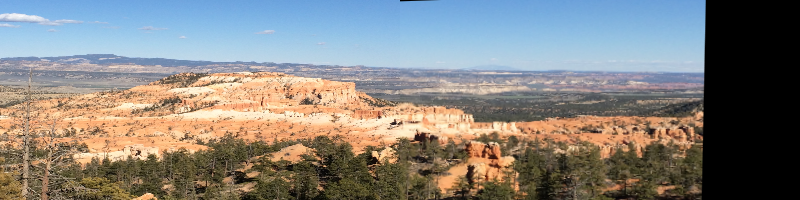

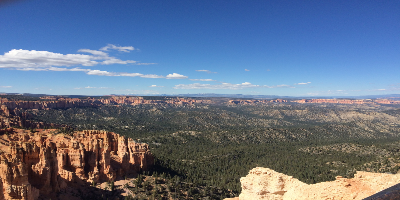

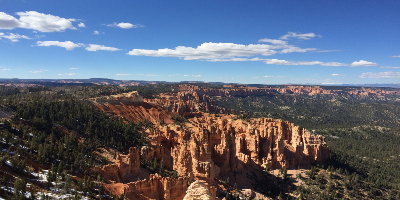

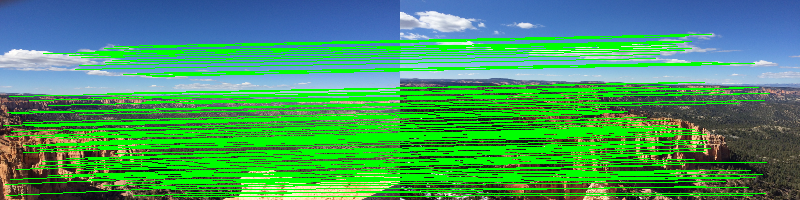

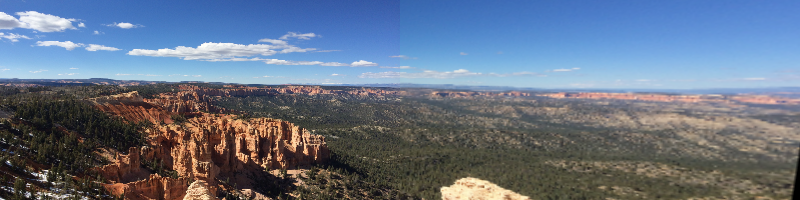

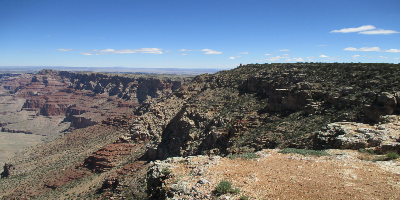

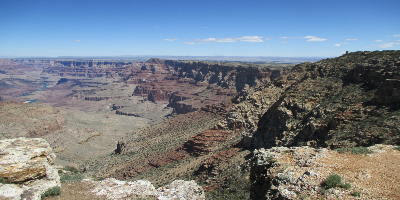

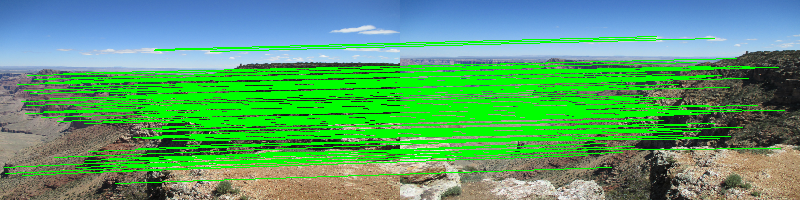

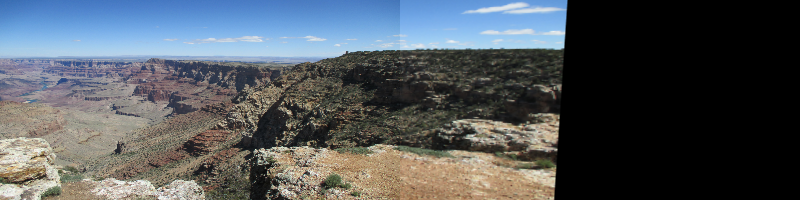

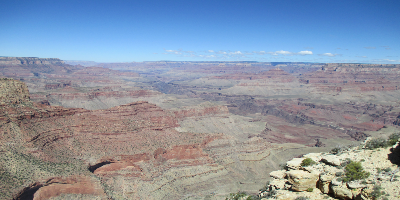

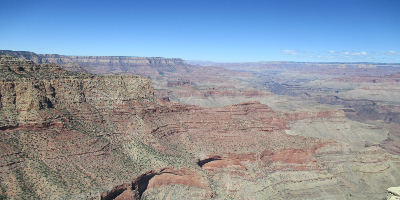

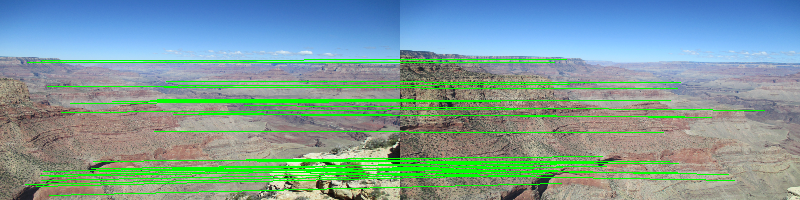

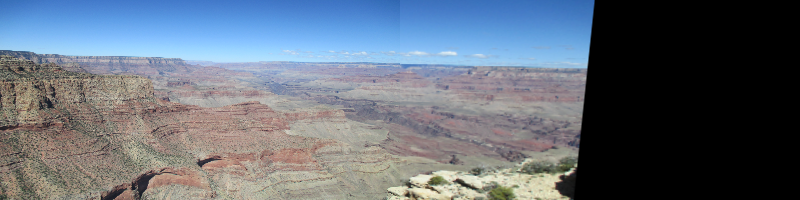

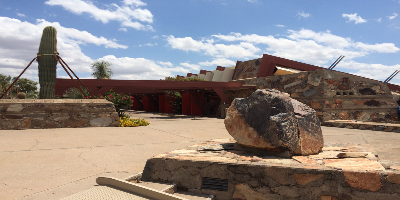

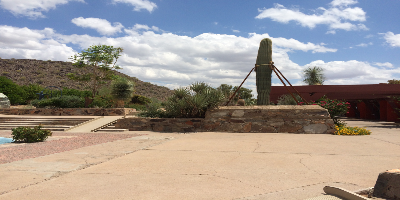

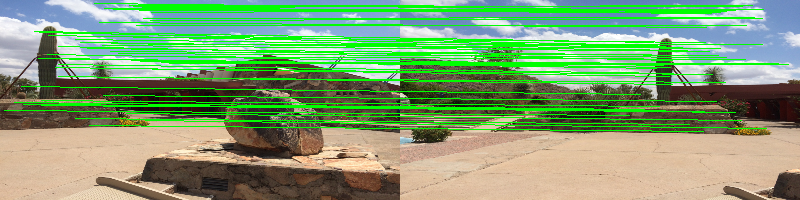

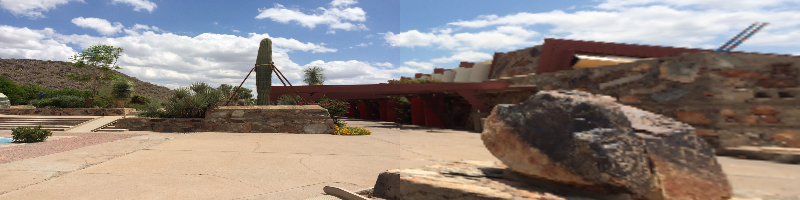

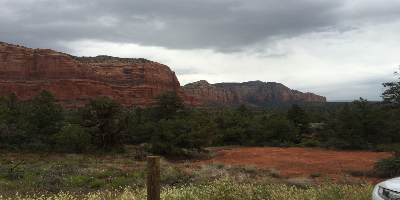

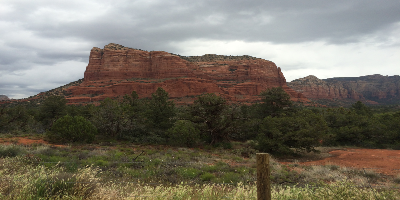

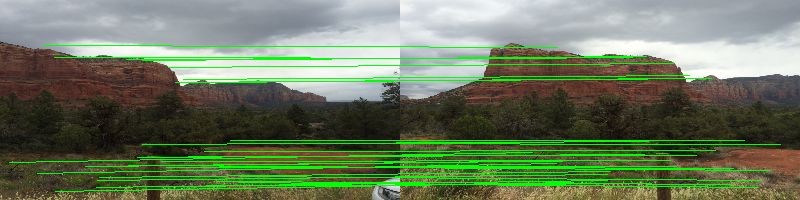

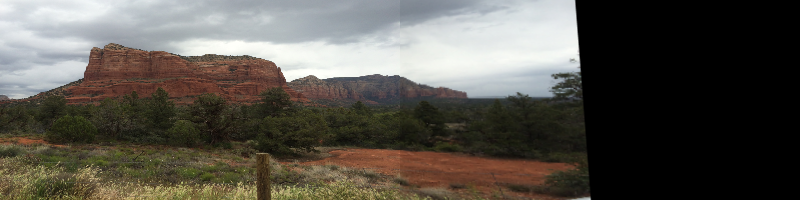

In [30]:
# USAGE
# python stitch.py --first images/bryce_left_01.png --second images/bryce_right_01.png

# import the necessary packages
import glob


import cv2


images = glob.glob("/content/drive/MyDrive/PanoramaImages/*.png")

left_images = [img for img in images if img.__contains__("_left_")]
left_images.sort()
right_images = [img for img in images if img.__contains__("_right_")]
right_images.sort()

for left_img_path, right_img_path in zip(left_images, right_images):
    # load the two images and resize them to have a width of 400 pixels
    # (for faster processing)
    imageA = cv2.imread(right_img_path)
    imageB = cv2.imread(left_img_path)
    imageA = cv2.resize(imageA,(400,200))
    imageB = cv2.resize(imageB,(400,200))

    # stitch the images together to create a panorama
    stitcher = PanoramaGenerator()
    (result, vis) = stitcher.generate_panorama_image([imageA, imageB], showMatches=True)

    # show the images
    cv2_imshow(imageA)
    cv2_imshow(imageB)
    cv2_imshow(vis)
    cv2_imshow(result)
    cv2.waitKey(0)